<a href="https://colab.research.google.com/github/RichardMWarburton/ExploringCUAD/blob/Dev/Individual%20Clause%20Investigation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Individual Clause Investigation

## The Data

CUAD: An Expert-Annotated NLP Dataset for Legal Contract Review

https://arxiv.org/abs/2103.06268

This code is an adaptation of the scrape.py file avaliable on the github repository for CUAD.  It has been adapted to run in Jypter notebooks and allow us to step throght the coding line by line.`

## 1: Import Packages & Define Useful Functions

In [232]:
from zipfile import ZipFile
import json
import os
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import re
from random import sample, choice
import numpy as np
import pandas as pd

In [233]:
def extract_zip(pth,data_pth = None):
    """Function to extract contents of a zip file to a specified location (wd if data_pth not passed)"""
    with ZipFile(pth, 'r') as zipObj:
       # Extract all the contents of zip file in different directory
       zipObj.extractall(data_pth)

## 2: Download repository and extract data

In [234]:
#Download CUAD git repository
if not os.path.exists('main.zip'):
  !wget --no-check-certificate https://github.com/TheAtticusProject/cuad/archive/refs/heads/main.zip
  !unzip -q main.zip

#If it has not already been extracted, extract the contents of data.zip
if not os.path.exists('cuad-main/data'):
  os.makedirs('cuad-main/data')

if not os.path.exists('cuad-main/data/CUADv1.json'):
  extract_zip('cuad-main/data.zip','cuad-main/data/')

#Download a manualy curated set of labels for the full CUAD data. 
if not os.path.exists('labels3.txt'):
  !wget https://raw.githubusercontent.com/RichardMWarburton/ExploringCUAD/main/labels3.txt

In [235]:
#Load CUADv1 JSON to data
with open('cuad-main/data/CUADv1.json','r') as infile:
    for line in infile:
        contract_data = json.loads(line)

### 2.1: Read in Label Data & Generate Look Up Dictionary

In [236]:
#Initate storage for labels look up (LU)
labels_LU = {}

#Read in labels data
with open('labels3.txt','r',encoding ='UTF-8') as infile:
  for line in infile:
    #Remove trailing special characters and split on tab
    data = line.strip().split(sep='\t')
    #Add name and label to labels_LU dictionary
    labels_LU[data[0]] = data[1]

The look up returns one error, most likely due to the accented E and a disparity of encoding.  This will be forced to 'Marketing Agreement' manually for now (EITHER SORT OR PROVIDE EXAMPLE)

### 2.2: Extract Raw Contract Data

In [237]:
#ser reg ex expression for characters to remove from contract contest
spec_chars = '\\n|\\t|\\t'

#Set number of contracts in data
num_contracts = len(contract_data['data'])

#Initate dictionary to store raw contract data
raw_contracts = defaultdict(list)

#for each contract
for i in range(num_contracts):
  #Append the title, contract text and character length of text to the raw_contracts dictionary
  raw_contracts['contract title'].append(contract_data['data'][i]['title'])
  raw_contracts['label'].append(labels_LU[contract_data['data'][i]['title']] if contract_data['data'][i]['title'] in labels_LU else 'marketing agreement' ) #<- manual error trap applied here (see below)
  
  #Parse raw text and process to remove breaks
  raw_text = contract_data['data'][i]['paragraphs'][0]['context']
  clean_text = re.sub(spec_chars,'',raw_text)

  #Split clean text in to sentances and tokens
  sentance_text = clean_text.split(sep = '. ')
  token_text = clean_text.split(sep = ' ')

  #Append text to the respective key in the raw_contracts dictionary
  raw_contracts['raw text'].append(raw_text)
  raw_contracts['clean text'].append(clean_text)
  raw_contracts['sentance text'].append(sentance_text)
  raw_contracts['token text'].append(token_text)
  
  #Add character, sentance and token counts to raw_contracts dictionary
  raw_contracts['character count'].append(len(raw_text))
  raw_contracts['sentance count'].append(len(sentance_text))
  raw_contracts['token count'].append(len(token_text))


In [238]:
#Sanity check value lists for each key ahve the correct length (510)
for key in raw_contracts:
  print(key,len(raw_contracts[key]))

contract title 510
label 510
raw text 510
clean text 510
sentance text 510
token text 510
character count 510
sentance count 510
token count 510


### 2.3: Extract Clause Specific Data

In [239]:
#Define the number of clauses
num_clauses = 41

#initate dictioanry to store caluse data
clause_data = defaultdict(list)

#For each contract
for i in range(num_contracts):
  #for each clause
  for j in range(num_clauses):
    #for each found clause annotation
    for k in range(len(contract_data['data'][i]['paragraphs'][0]['qas'][j]['answers'])): 
      #Add the contract title
      clause_data['contract title'].append(contract_data['data'][i]['title'])
      clause_data['label'].append(labels_LU[contract_data['data'][i]['title']] if contract_data['data'][i]['title'] in labels_LU else 'marketing agreement' )  #<- manual error trap applied here
      clause_data['clause'].append(contract_data['data'][i]['paragraphs'][0]['qas'][j]['id'].split(sep='__')[1])
      clause_data['annotation'].append(contract_data['data'][i]['paragraphs'][0]['qas'][j]['answers'][k]['text'])
      clause_data['annotation start'].append(contract_data['data'][i]['paragraphs'][0]['qas'][j]['answers'][k]['answer_start'])
      clause_data['annotation length'].append(len(contract_data['data'][i]['paragraphs'][0]['qas'][j]['answers'][k]['text']))


In [240]:
#Sanity check value lists for each key ahve the correct length (13823)
for key in clause_data:
  print(key,len(clause_data[key]))

contract title 13823
label 13823
clause 13823
annotation 13823
annotation start 13823
annotation length 13823


In [241]:
np.unique(clause_data['clause'])

array(['Affiliate License-Licensee', 'Affiliate License-Licensor',
       'Agreement Date', 'Anti-Assignment', 'Audit Rights',
       'Cap On Liability', 'Change Of Control',
       'Competitive Restriction Exception', 'Covenant Not To Sue',
       'Document Name', 'Effective Date', 'Exclusivity',
       'Expiration Date', 'Governing Law', 'Insurance',
       'Ip Ownership Assignment', 'Irrevocable Or Perpetual License',
       'Joint Ip Ownership', 'License Grant', 'Liquidated Damages',
       'Minimum Commitment', 'Most Favored Nation',
       'No-Solicit Of Customers', 'No-Solicit Of Employees',
       'Non-Compete', 'Non-Disparagement', 'Non-Transferable License',
       'Notice Period To Terminate Renewal', 'Parties',
       'Post-Termination Services', 'Price Restrictions', 'Renewal Term',
       'Revenue/Profit Sharing', 'Rofr/Rofo/Rofn', 'Source Code Escrow',
       'Termination For Convenience', 'Third Party Beneficiary',
       'Uncapped Liability', 'Unlimited/All-You-Can-Eat

## 3: Cleaning data for a single clause

In [433]:
#Define clause of interest
clause_of_interest = 'Governing Law'

#Initate dataframe of all clause data
clause_df = pd.DataFrame(clause_data)

clause_df['annotation'] = clause_df['annotation'].apply(lambda x: x.replace('  ',' '))
clause_df['annotation'] = clause_df['annotation'].apply(lambda x: x.strip())

#Limit df to clause of interest and extract annotations of itnerest
of_interest_data = clause_df[clause_df['clause'] == clause_of_interest]
annotations_of_interest = of_interest_data['annotation'].values

#Identify where there are multiple annotations per contract
titles,counts = np.unique(of_interest_data['contract title'],return_counts =True)
dups = titles[counts >= 2]

#Output Analysis
print('There are {} contracts with \'{}\' annotations'.format(*(titles.shape[0],clause_of_interest)))
print('There are {} contracts with more than one annotation'.format(dups.shape[0]))

There are 437 contracts with 'Governing Law' annotations
There are 25 contracts with more than one annotation


From the above we can see that: 

1.   Contracts may have multiple annotations for the same clause
2.   Not all contracts have an annotation of interest

Provisionally, we will look to concatinate all such annotations for a contract in to one string.  This will then represent all the salient points for the contract and clause in question.

In [438]:
#output duplicate annotations anc contract titles
dup_df = of_interest_data[of_interest_data['contract title'].isin(dups)][['contract title','annotation']]

#print sample of duplicate annotations
for i in dup_df.index[:8]:
  print(dup_df.loc[i,'contract title'])
  print(dup_df.loc[i,'annotation'])
  print('\n')

ChinaRealEstateInformationCorp_20090929_F-1_EX-10.32_4771615_EX-10.32_Content License Agreement
This Termination Agreement shall be governed by the laws of the PRC, without regard to conflicts of law principles.


ChinaRealEstateInformationCorp_20090929_F-1_EX-10.32_4771615_EX-10.32_Content License Agreement
This Agreement and any dispute or claim arising out of or in connection with it or its subject matter shall be governed by, and construed in accordance with, the laws of the People's Republic of China (without regard to its conflicts of laws rules that would mandate the application of the laws of another jurisdiction).


LOYALTYPOINTINC_11_16_2004-EX-10.2-RESELLER AGREEMENT
This Agreement shall be subject to and governed by the laws of the     State of Missouri, USA.


LOYALTYPOINTINC_11_16_2004-EX-10.2-RESELLER AGREEMENT
This Agreement shall be deemed to have been made and executed          in the State of Missouri and any dispute arising thereunder          shall be resolved in a

In [381]:
#Initate memory for annotations within contracts
combined_annotations_list = defaultdict(list)
combined_annotations_string = {}

#For each annotation of interest found in the contract, 
#append annotation to a default dict list with contract as key
for i in of_interest_data.index:
  name = of_interest_data.loc[i,['contract title']].values[0]
  annotation = of_interest_data.loc[i,['annotation']].values[0]
  combined_annotations_list[name].append(annotation)

#Produce a singel string of all annotations found in specific contracts
for key in combined_annotations_list.keys():
  combined_annotations_string[key] = ' '.join(combined_annotations_list[key])

In [443]:
#Build array of contract names and concatenated annotations
contracts = np.array(list(combined_annotations_string.keys()))
combined_annotations = np.array(list(combined_annotations_string.values()))

#Could add first annotation as well

## Section 4: Vectorizing Single Clause Data

In [444]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range = (1,10),stop_words ='english',max_features=175)
X = vectorizer.fit_transform(combined_annotations).toarray()


In [384]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6, random_state=42).fit(X)
labs = kmeans.labels_

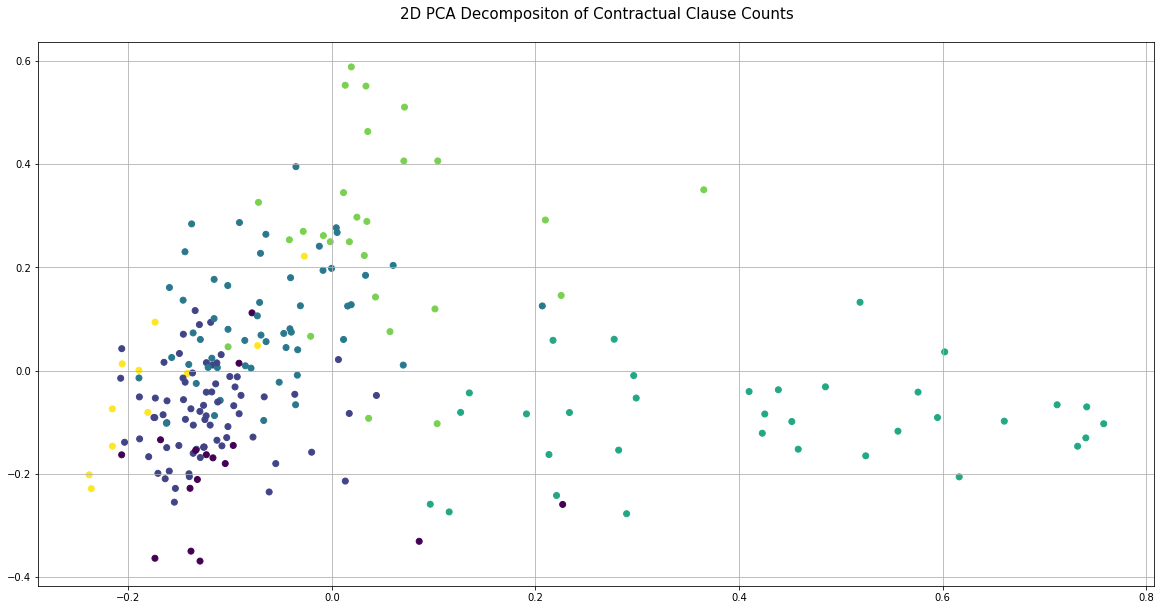

Explained variance ratios: [0.05778136 0.03733918]
Total variance explained in 2 principal components: 0.09512053816838391


In [385]:
from sklearn.decomposition import PCA
#Decompose clause counts in to 2D via PCA analysis
pca = PCA(n_components=2)
pca_data_2D = pca.fit_transform(X)

#Extract first two principal components to plot
x = pca_data_2D[:,0]
y = pca_data_2D[:,1]

#Plot first two principal components
plt.figure(figsize = (20,10))
plt.title('2D PCA Decompositon of Contractual Clause Counts\n', size = 15)
plt.scatter(x,y, c = labs)
plt.grid()
plt.show()

print('Explained variance ratios: {}'.format(pca.explained_variance_ratio_))
print('Total variance explained in 2 principal components: {}'.format(pca.explained_variance_ratio_.sum()))


In [386]:
from sklearn.manifold import TSNE
n_clust=6

X_raw = np.array(list(combined_annotations_string.values()))

X = vectorizer.fit_transform(X_raw).toarray()

X_tsne = TSNE(n_components=2).fit_transform(X)

kmeans = KMeans(n_clusters=n_clust, random_state=42).fit(X_tsne)
labs_tsne = kmeans.labels_

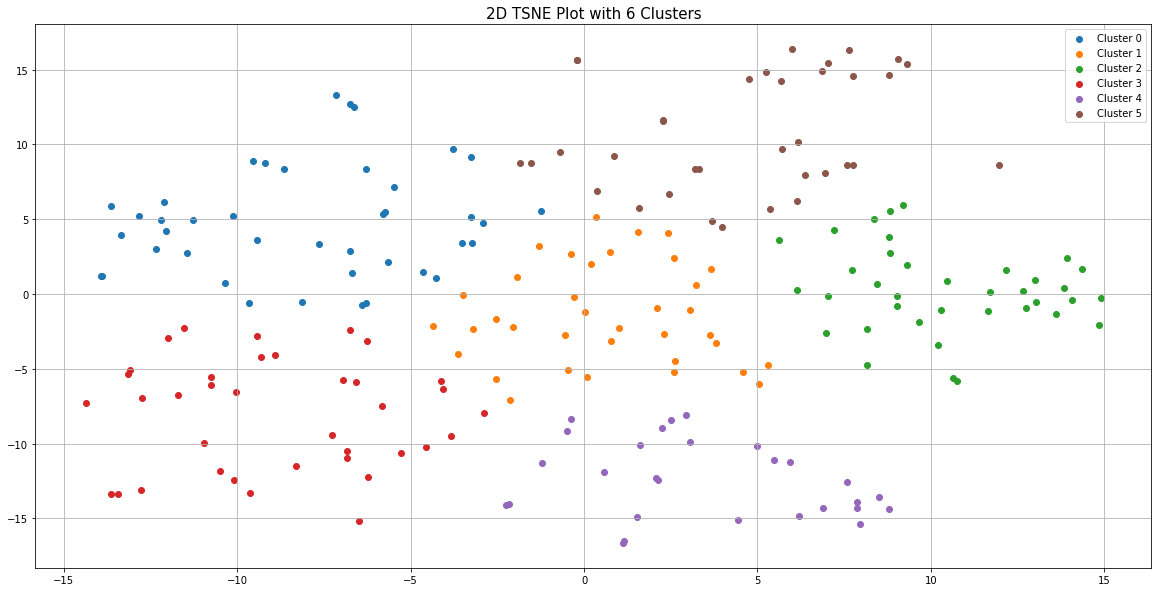

In [387]:
#Extract first two principal components to plot
x_tsne = X_tsne[:,0]
y_tsne = X_tsne[:,1]

#Plot first two principal components
plt.figure(figsize = (20,10))
plt.title('2D TSNE Plot with {} Clusters'.format(n_clust), size = 15)

for i in np.unique(labs_tsne):
  idx = labs_tsne == i
  plt.scatter(x_tsne[idx],y_tsne[idx],label ='Cluster {}'.format(str(i)))

plt.legend()
plt.grid()
plt.show()

In [388]:
#Import all the dependencies
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [389]:
X = list(combined_annotations_string.values())
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(X)]



In [393]:
word_tokenize(X[0].lower())

['during',
 'the',
 'term',
 ',',
 'and',
 'for',
 'a',
 'period',
 'of',
 '[',
 '*',
 ']',
 'thereafter',
 ',',
 'google',
 'may',
 'audit',
 'distributor',
 "'s",
 'relevant',
 'records',
 'to',
 'confirm',
 'distributor',
 "'s",
 'compliance',
 'with',
 'this',
 'agreement',
 '.']

taggec_data

In [390]:
max_epochs = 100
vec_size = 100
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
print("Model Saved")

/usr/local/lib/python3.7/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


iteration 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration 77
iteratio

In [391]:
#Intate array of correct size
Xt = np.zeros((len(X),vec_size))

#Add values in to correct row
for j in range(len(X)):
  Xt[j,:] = model.docvecs[j]

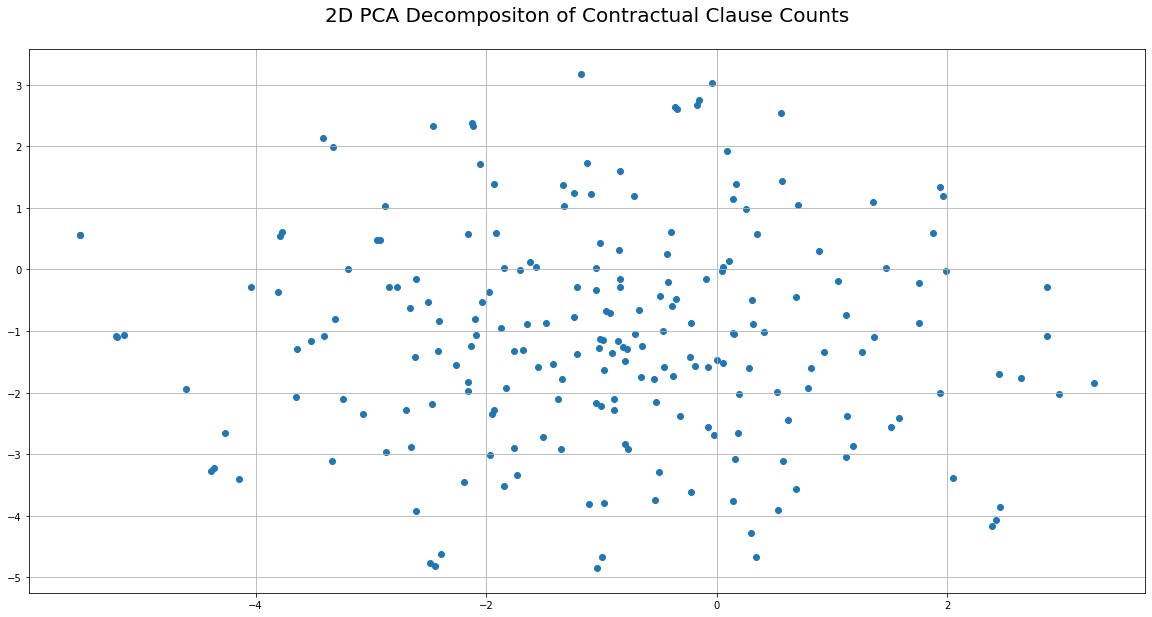

In [392]:
#Decompose clause counts in to 2D via PCA analysis
#pca = PCA(n_components=2)
#pca_data_2D = pca.fit_transform(Xt)

#Extract first two principal components to plot
#x_d2v = pca_data_2D[:,0]
#y_d2v = pca_data_2D[:,1]


X_d2v_tsne = TSNE(n_components=2).fit_transform(Xt)

x = X_d2v_tsne[:,0]
y = X_d2v_tsne[:,1]

#Plot first two principal components
plt.figure(figsize = (20,10))
plt.title('2D PCA Decompositon of Contractual Clause Counts\n', size = 20)
plt.scatter(x,y)
plt.grid()
plt.show()